In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir('drive/Tensorflow/Ensemble_Learning')

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [4]:
import tensorflow as tf
from tensorflow.keras import  Sequential
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import InputLayer, Input, Reshape, MaxPool2D, Conv2D, Dense, Flatten, Activation, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D 
from tensorflow.keras import regularizers, optimizers
from keras.initializers import glorot_uniform


Using TensorFlow backend.


In [5]:
#Read the data from mnist in tensofflow
from tensorflow.examples.tutorials.mnist import input_data
data=input_data.read_data_sets('data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
print('Size of training set: \t\t{}'.format(len(data.train.labels)))
print('Size of test set: \t\t{}'.format(len(data.test.labels)))
print('Size of validation set: \t{}'.format(len(data.validation.labels)))

Size of training set: 		55000
Size of test set: 		10000
Size of validation set: 	5000


In [0]:
#Define some static variables

img_size= 28 # Image size
img_size_flat= img_size*img_size
num_classes=10 #Number of the classes
num_channels=1 # Number of channel 

###Load data

In [0]:
X_train_org=np.array(data.train.images.reshape((-1, img_size, img_size)))
X_test_org=np.array(data.test.images.reshape((-1, img_size, img_size)))
X_validation_org=np.array(data.validation.images.reshape((-1, img_size, img_size)))

y_train=np.array(data.train.labels)
y_test=np.array(data.test.labels)
y_validation=np.array(data.validation.labels)

y_train_cls=np.argmax(y_train, axis=1)
y_test_cls=np.argmax(y_test, axis=1)
y_validation_cls=np.argmax(y_validation, axis=1)

### Create the random training-set

In [0]:
#Concatenate the training set and validation set
train_vali_org=np.concatenate([X_train_org, X_validation_org], axis=0)
train_vali_labels=np.concatenate([y_train, y_validation], axis=0)

In [12]:
print(train_vali_org.shape)
print(train_vali_labels.shape)

(60000, 28, 28)
(60000, 10)


In [14]:
#Define the size of the random training set (80 % of the train_vali_set)
train_size= int(0.8*len(train_vali_org))
print(train_size)

48000


In [0]:
#Define a fucntion to get the random training set and validation set from the train_vali_set
def get_random_training_set():
    #Random the index
    idx=np.random.permutation(len(train_vali_org))

    #Create the index random training set and validation
    idx_train=idx[0: train_size]
    idx_vali=idx[train_size:]

    #Create the random training set and validation
    X_train_org=train_vali_org[idx_train, :]
    X_validation_org=train_vali_org[idx_vali, :]

    y_train=train_vali_labels[idx_train, :]
    y_validation=train_vali_labels[idx_vali, :]

    y_train_cls=np.argmax(y_train, axis=1)
    y_validation_cls=np.argmax(y_validation, axis=1)

    return X_train_org, y_train, X_validation_org, y_validation, y_train_cls, y_validation_cls

###Function to plot images

In [0]:
def plot_images(images, cls_true, best_cls_pred=None, ensemble_cls_pred=None):
    plt.figure(figsize=(10,10))
    
    for i in range(min(25, len(images))):
        plt.subplot(5, 5, i+1)
        if ensemble_cls_pred is None and best_cls_pred is None:
            plt.xlabel('True {0}'.format(cls_true[i]))
        elif ensemble_cls_pred is None and best_cls_pred is not None:
            plt.xlabel('True {0}, Pred: {1}'.format(cls_true[i], best_cls_pred[i]))
        elif ensemble_cls_pred is not None and best_cls_pred is not None:
            plt.xlabel('True {0},\n Pred: {1},\n Ensem: {2}'.format(cls_true[i], best_cls_pred[i], ensemble_cls_pred[i]))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
    plt.show()


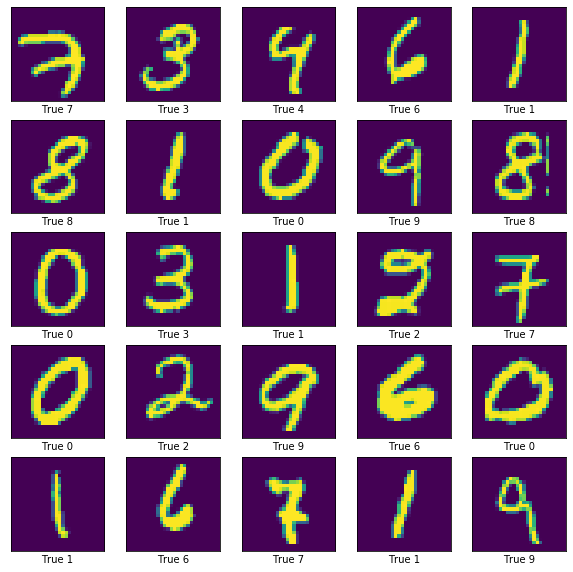

In [17]:
## Plot some images to see the true label in train dataset

plot_images(X_train_org, y_train_cls)

### Create ensemble and design the model 

In [0]:
# Create the fix model
def fix_model():
    X_input=Input(shape=(img_size, img_size))

    #Reshape the input
    inputs= Reshape((img_size, img_size, num_channels)) (X_input)

    #First layeyes with re-lu activation and maxpooling
    inputs=Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu') (inputs)
    inputs=MaxPool2D(pool_size=2, strides=2) (inputs)

    #Second layer with relu function and max pooling
    inputs=Conv2D(filters=36, kernel_size=5, strides=1, padding='same', activation='relu') (inputs)
    inputs=MaxPool2D(pool_size=2, strides=2) (inputs)

    #Flatten layers
    inputs=Flatten() (inputs)

    #Fully conected
    inputs=Dense(128, activation='relu') (inputs)

    #Last fully connected layers
    inputs=Dense(num_classes, activation='softmax') (inputs)

    outputs=inputs
    model=Model(inputs=X_input, outputs=outputs)
    return model

In [0]:
# Define the function to get the prediction of ensemble (mean of the predictions of networks)
def ensemble_predictions(models, test):
    prediction=[]
    for model in models:
        prediction.append(model.predict(test))
    prediction=np.array(prediction)
    prediction=np.mean(prediction, axis=0)
    prediction_cls=np.argmax(prediction, axis=1)
    return prediction, prediction_cls

In [0]:
# Compute the accuracy of the ensemble
def ensemble_acc(prediction_cls):
    correct_prediction=np.sum(prediction_cls==y_test_cls)
    return correct_prediction/ len(prediction_cls)

In [0]:
# Compute the accuracy of individual network
def evalutions(models):
    accuracies=[]
    for model in models:
        acc= model.evaluate(X_test, y_test)[1]
        accuracies.append(acc)
    return accuracies

In [0]:
#Define the number of network
num_net=5

In [0]:
#Normalize test set
X_test=X_test_org/255

In [36]:
# fit individual and save it
models=[]
for i in range(num_net):
    #Get the random training set
    X_train, y_train,_, _, _, _= get_random_training_set()
    X_train=X_train/255

    model=fix_model()
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=256, epochs=5)
    models.append(model)

Train on 48000 samples
Epoch 1/5
48000/48000 [==============================] - 46s 957us/sample - loss: 1.4467 - acc: 0.5365
Epoch 2/5
48000/48000 [==============================] - 45s 947us/sample - loss: 0.4249 - acc: 0.8750
Epoch 3/5
48000/48000 [==============================] - 45s 948us/sample - loss: 0.3097 - acc: 0.9065
Epoch 4/5
48000/48000 [==============================] - 46s 949us/sample - loss: 0.2513 - acc: 0.9234
Epoch 5/5
48000/48000 [==============================] - 45s 943us/sample - loss: 0.2114 - acc: 0.9348
Train on 48000 samples
Epoch 1/5
48000/48000 [==============================] - 45s 946us/sample - loss: 1.6262 - acc: 0.4528
Epoch 2/5
48000/48000 [==============================] - 46s 956us/sample - loss: 0.4466 - acc: 0.8665
Epoch 3/5
48000/48000 [==============================] - 46s 957us/sample - loss: 0.3212 - acc: 0.9021
Epoch 4/5
48000/48000 [==============================] - 46s 961us/sample - loss: 0.2627 - acc: 0.9194
Epoch 5/5
48000/48000 [====

### Ensemble and best model

In [59]:
accuracies=evalutions(models)
#The accuracy of the best model
print('Accuracy of the best model {0}'.format(np.max(accuracies)))

10000/10000 [==============================] - 5s 456us/sample - loss: 0.2122 - acc: 0.9357
Accuracy of the best model 0.9451000094413757


In [0]:
#Get the best model
best_model=models[np.argmax(accuracies)]

#The predictions of best model
best_pred=best_model.predict(X_test)
best_pred_cls=np.argmax(best_pred, axis=1)

In [61]:
#Get the pedictions of the ensemble model
ensenble_pred, ensenble_pred_cls =ensemble_predictions(models, X_test)

#Get the accuracy of the ensemble
print(ensemble_acc(ensenble_pred_cls))

0.9443


### Comprision 

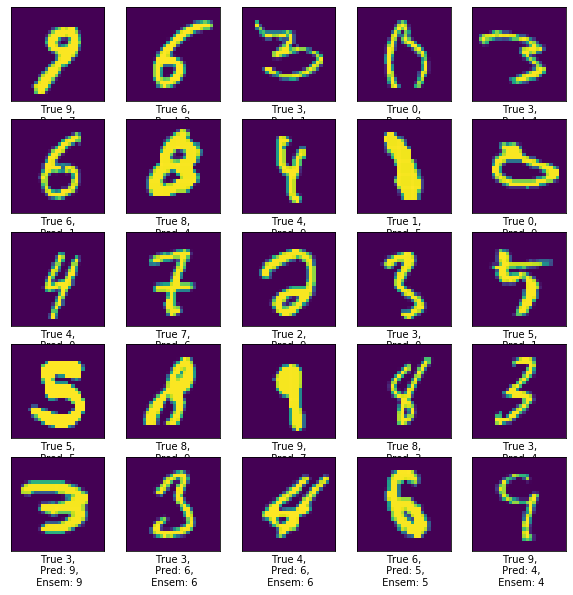

In [66]:
#plot the predictions 

#Get the data that has differnt prediction fropm best model and ensemble 
mask= best_pred_cls !=ensenble_pred_cls

plot_images(X_test_org[mask], y_test_cls[mask], best_pred_cls, ensenble_pred_cls)